In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind

Load and Merge the data

In [2]:
application_data=pd.read_csv("data/application_data.csv")
previous_application=pd.read_csv("data/previous_application.csv")

In [3]:
# Merge application_data and previous_application_data
merged_data = pd.merge(application_data, previous_application, on='SK_ID_CURR', how='left')

In [4]:
merged_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


In [5]:
merged_data.shape

(1430155, 158)

In [6]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Columns: 158 entries, SK_ID_CURR to NFLAG_INSURED_ON_APPROVAL
dtypes: float64(85), int64(41), object(32)
memory usage: 1.7+ GB


In [7]:
merged_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430062e+06,1.428936e+06,1.430155e+06,1.430155e+06,1.430155e+06,...,4791.000000,1.413701e+06,1.413701e+06,1.106488e+06,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000,852595.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704203e+04,5.294435e+05,2.079102e-02,-1.631495e+04,6.860209e+04,...,0.771284,-8.803670e+02,3.149878e+02,1.605194e+01,342257.656710,13488.741567,33274.831806,76665.634755,82353.171672,0.330572
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404002e+04,3.557882e+05,1.339810e-02,4.346737e+03,1.451967e+05,...,0.100644,7.835402e+02,7.695082e+03,1.456675e+01,88832.266598,71650.147146,106161.775933,149704.716371,153537.064274,0.470419
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,1.615500e+03,4.050000e+04,2.900000e-04,-2.522900e+04,-1.791200e+04,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,...,0.715645,-1.313000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1630.000000,-1244.000000,-1316.000000,-1269.000000,0.000000
50%,2.789560e+05,0.000000e+00,0.000000e+00,1.575000e+05,5.084955e+05,2.491650e+04,4.500000e+05,1.885000e-02,-1.603700e+04,-1.277000e+03,...,0.835095,-5.820000e+02,4.000000e+00,1.200000e+01,365243.000000,-825.000000,-358.000000,-534.000000,-494.000000,0.000000
75%,3.675090e+05,0.000000e+00,1.000000e+00,2.115000e+05,8.086500e+05,3.457350e+04,6.795000e+05,2.866300e-02,-1.272950e+04,-2.820000e+02,...,0.852537,-2.710000e+02,8.500000e+01,2.400000e+01,365243.000000,-408.000000,135.000000,-73.000000,-42.000000,1.000000
max,4.562550e+05,1.000000e+00,1.900000e+01,1.170000e+08,4.050000e+06,2.580255e+05,4.050000e+06,7.250800e-02,-7.489000e+03,3.652430e+05,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [8]:
merged_data.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE_x              0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
DAYS_FIRST_DUE               577560
DAYS_LAST_DUE_1ST_VERSION    577560
DAYS_LAST_DUE                577560
DAYS_TERMINATION             577560
NFLAG_INSURED_ON_APPROVAL    577560
Length: 158, dtype: int64

In [9]:
merged_data.fillna(0,inplace=True)

In [10]:
merged_data.isnull().sum()

SK_ID_CURR                   0
TARGET                       0
NAME_CONTRACT_TYPE_x         0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
                            ..
DAYS_FIRST_DUE               0
DAYS_LAST_DUE_1ST_VERSION    0
DAYS_LAST_DUE                0
DAYS_TERMINATION             0
NFLAG_INSURED_ON_APPROVAL    0
Length: 158, dtype: int64

In [11]:
merged_data.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
271312,167922,0,Cash loans,F,N,Y,2,202500.0,675000.0,21906.0,...,XNA,0.0,XNA,Card X-Sell,-198.0,-169.0,365243.0,365243.0,365243.0,0.0
1357738,438290,0,Cash loans,M,Y,Y,0,270000.0,888840.0,32053.5,...,Consumer electronics,16.0,middle,POS household with interest,0.0,0.0,0.0,0.0,0.0,0.0
317031,179261,0,Cash loans,F,Y,Y,1,180000.0,288562.5,32688.0,...,XNA,0.0,XNA,Cash,0.0,0.0,0.0,0.0,0.0,0.0
1066258,365963,1,Cash loans,M,N,Y,0,135000.0,450000.0,24543.0,...,Consumer electronics,6.0,middle,POS household with interest,365243.0,-305.0,-155.0,-155.0,-152.0,1.0
1229306,405836,1,Cash loans,F,N,Y,0,76500.0,521280.0,35392.5,...,XNA,0.0,XNA,Cash,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(list(merged_data.columns))

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE_x', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x', 'AMT_GOODS_PRICE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START_x', 'HOUR_APPR_PROCESS_START_x', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONA

Client Profile Analysis

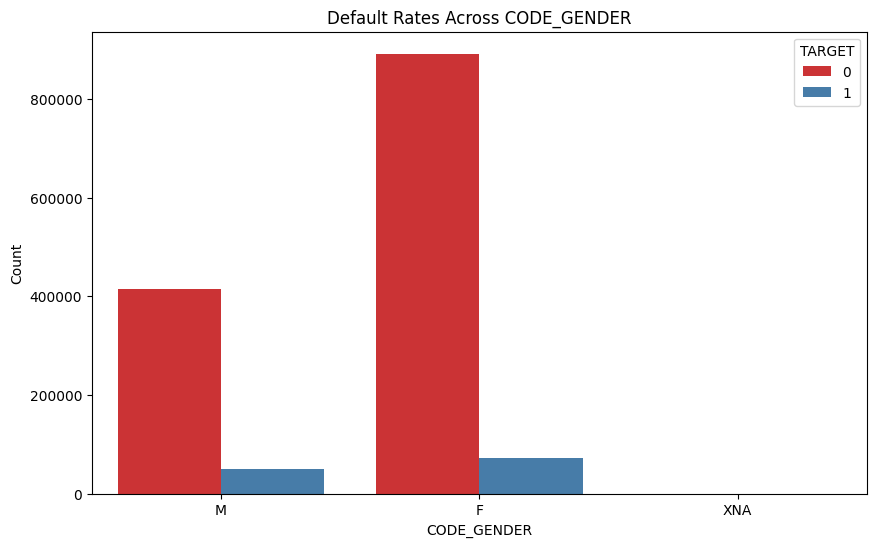

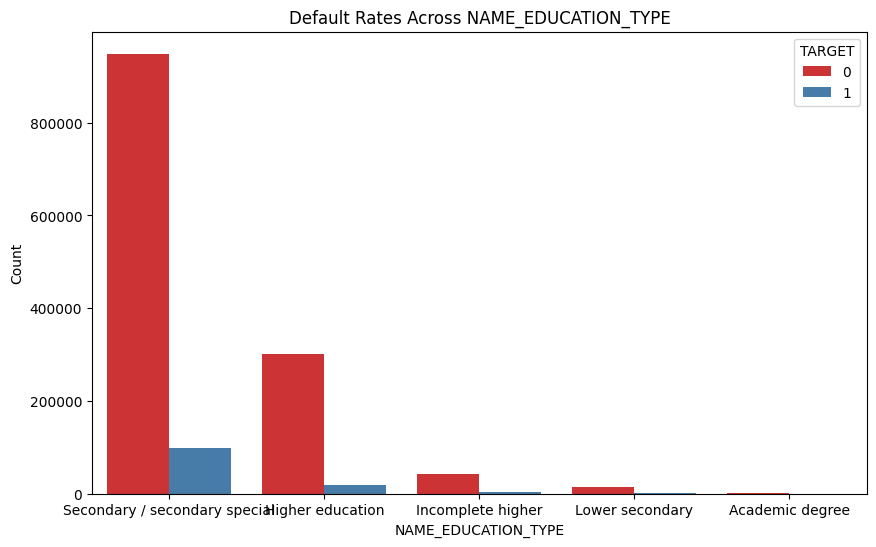

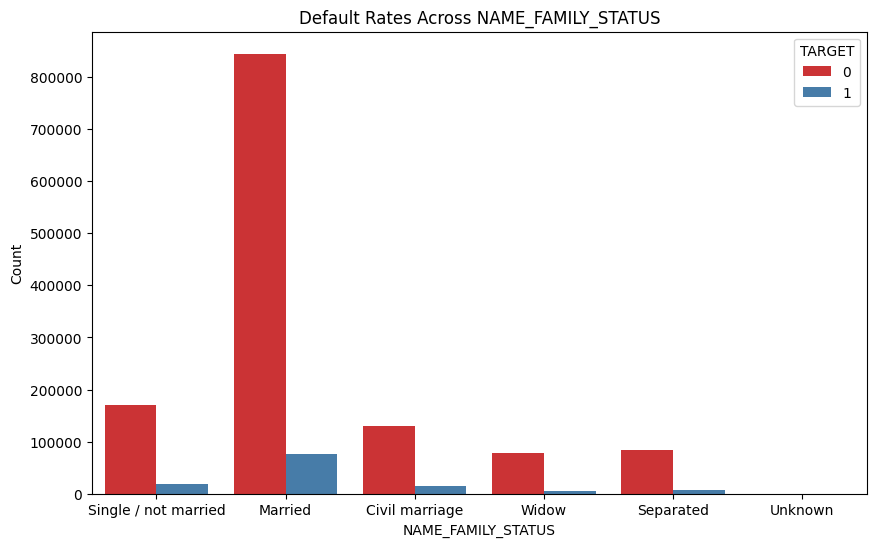

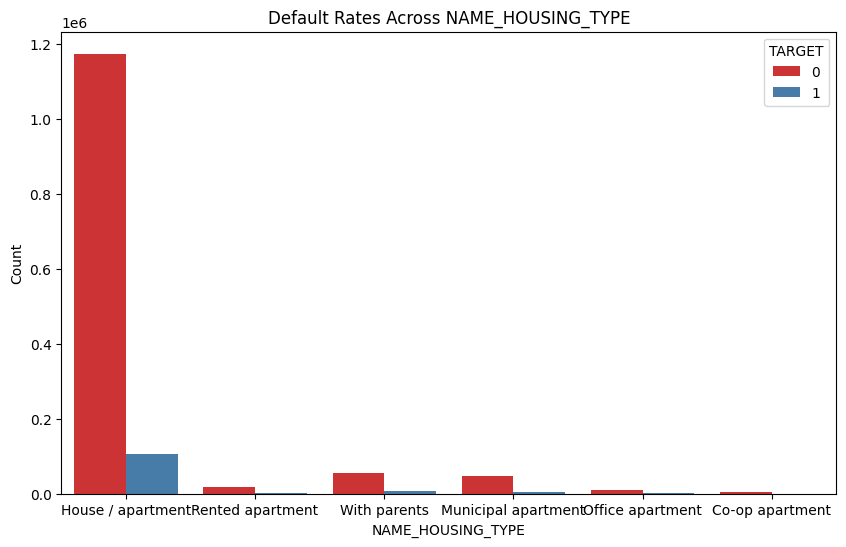

In [13]:
# Default rates across different demographic groups
demographic_groups = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

for group in demographic_groups:
    plt.figure(figsize=(10,6))
    sns.countplot(x=group,hue='TARGET',data=merged_data,palette='Set1')
    plt.title(f'Default Rates Across {group}')
    plt.xlabel(group)
    plt.ylabel('Count')
    plt.show()


In [14]:
# Statistical Analysis: Hypothesis Testing (Example: Difference in default rates between genders)
gender_default_cross_tab = pd.crosstab(merged_data['CODE_GENDER'], merged_data['TARGET'])
chi2_stat, p_val_gender = ttest_ind(gender_default_cross_tab.iloc[:, 0], gender_default_cross_tab.iloc[:, 1])
print("T-test p-value for gender and default rate:", p_val_gender)

T-test p-value for gender and default rate: 0.20159717846488764


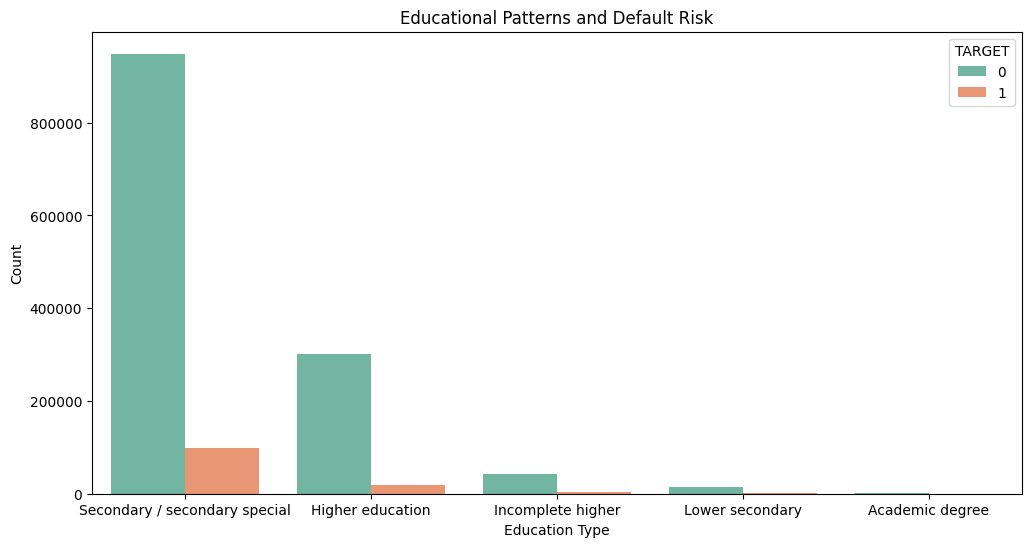

In [15]:
# Educational patterns associated with higher default risk
plt.figure(figsize=(12,6))
sns.countplot(x='NAME_EDUCATION_TYPE',hue='TARGET',data=merged_data,palette='Set2')
plt.title('Educational Patterns and Default Risk')
plt.xlabel('Education Type')
plt.ylabel('Count')
plt.show()

In [16]:
# Statistical Analysis: Correlation Analysis
# Select numeric columns for correlation analysis
numeric_columns = merged_data.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_columns.corr()
print(correlation_matrix)

                           SK_ID_CURR    TARGET  CNT_CHILDREN  \
SK_ID_CURR                   1.000000 -0.001216     -0.002966   
TARGET                      -0.001216  1.000000      0.020310   
CNT_CHILDREN                -0.002966  0.020310      1.000000   
AMT_INCOME_TOTAL            -0.000176 -0.002658      0.011766   
AMT_CREDIT_x                -0.001067 -0.024281      0.002738   
...                               ...       ...           ...   
DAYS_FIRST_DUE              -0.000857 -0.010133      0.007009   
DAYS_LAST_DUE_1ST_VERSION    0.000157  0.004119      0.005607   
DAYS_LAST_DUE               -0.000440 -0.001732     -0.000195   
DAYS_TERMINATION            -0.000356 -0.002751      0.001269   
NFLAG_INSURED_ON_APPROVAL    0.000611 -0.017839     -0.029329   

                           AMT_INCOME_TOTAL  AMT_CREDIT_x  AMT_ANNUITY_x  \
SK_ID_CURR                        -0.000176     -0.001067      -0.001658   
TARGET                            -0.002658     -0.024281      -0.0

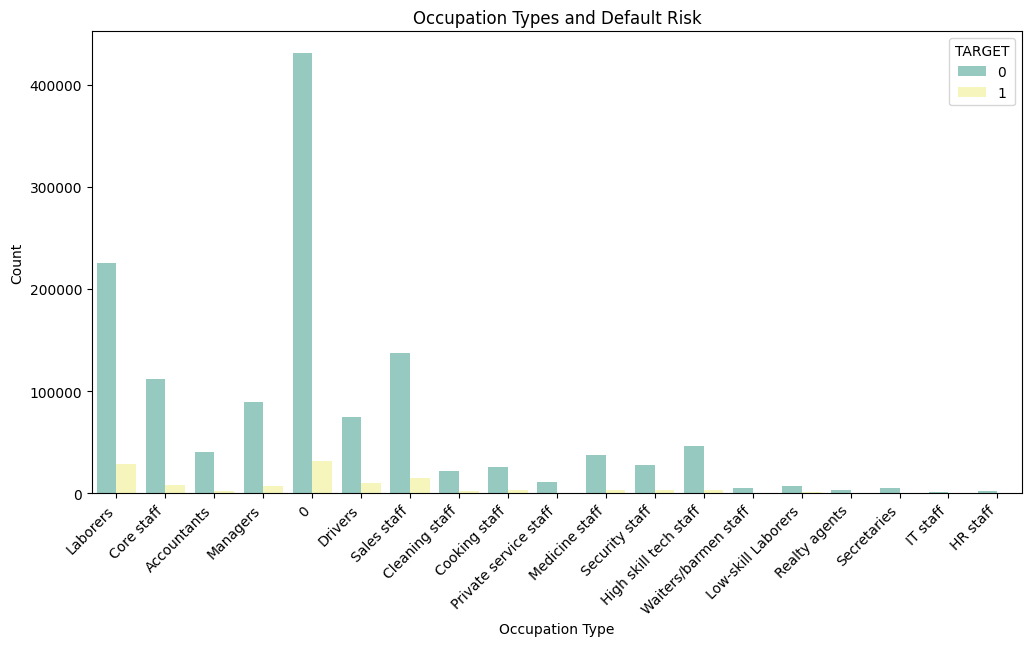

In [17]:
# Employment patterns associated with higher default risk
plt.figure(figsize=(12, 6))
sns.countplot(x='OCCUPATION_TYPE', hue='TARGET', data=merged_data, palette='Set3')
plt.title('Occupation Types and Default Risk')
plt.xlabel('Occupation Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\863450066.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=merged_data, palette='pastel')


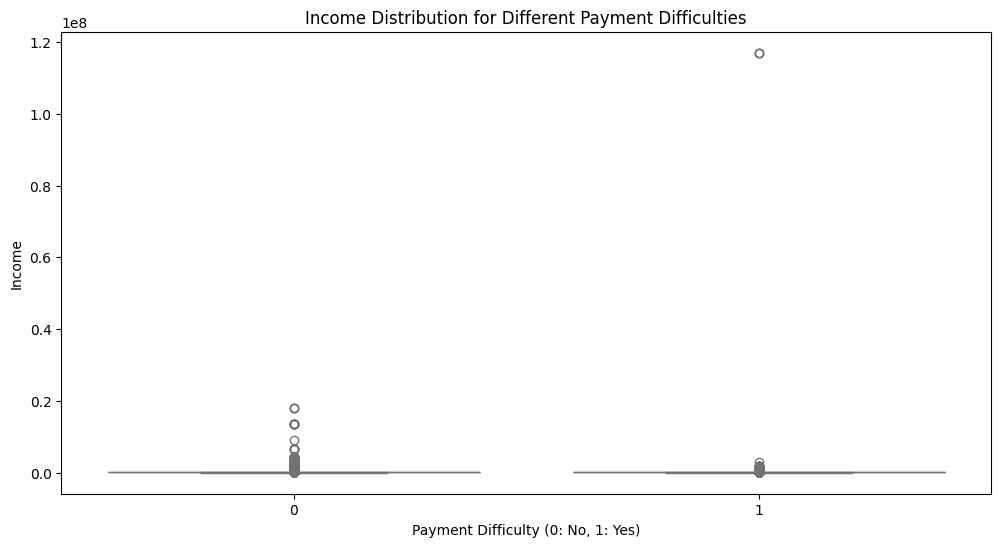

In [18]:
# Differences in client profiles between those with payment difficulties and those without
plt.figure(figsize=(12, 6))
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=merged_data, palette='pastel')
plt.title('Income Distribution for Different Payment Difficulties')
plt.xlabel('Payment Difficulty (0: No, 1: Yes)')
plt.ylabel('Income')
plt.show()

Financial Analysis

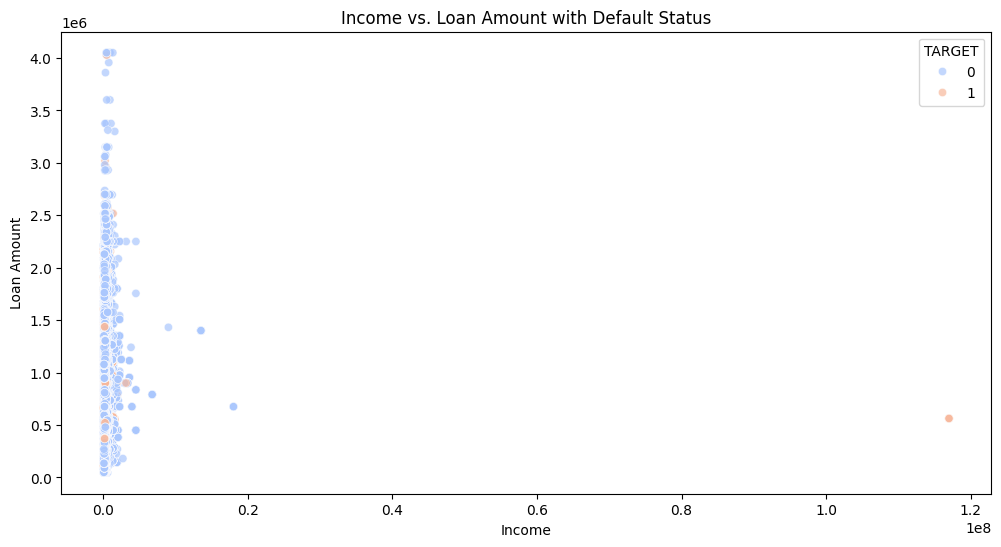

In [19]:
# Relationships between income, debt levels, and loan default probability
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT_x', hue='TARGET', data=merged_data, palette='coolwarm', alpha=0.7)
plt.title('Income vs. Loan Amount with Default Status')
plt.xlabel('Income')
plt.ylabel('Loan Amount')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\3882810402.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_14620\3882810402.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)


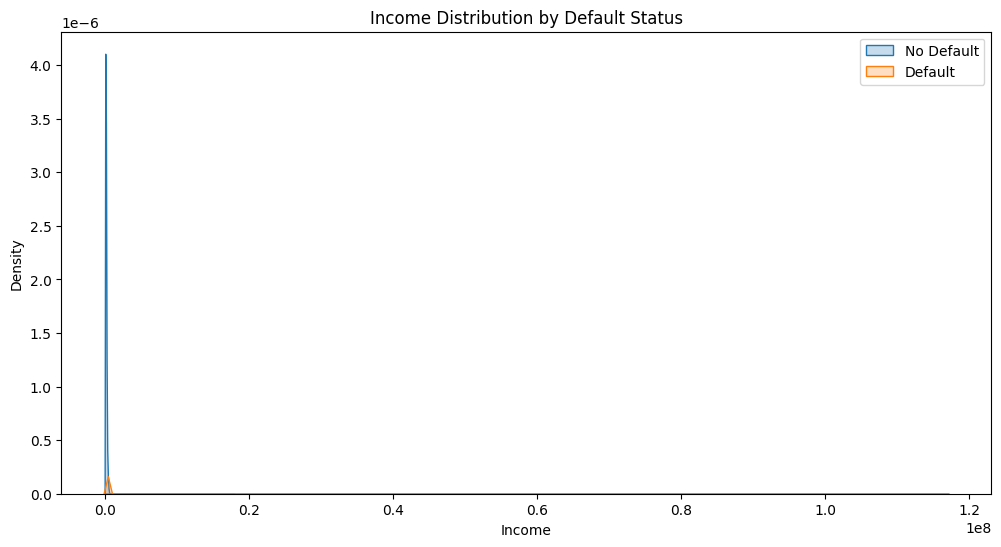

In [20]:
# Income distribution among loan applicants and its influence on loan amounts and approval rates
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)
plt.title('Income Distribution by Default Status')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

In [21]:
# Statistical Analysis: Correlation Analysis
income_credit_corr = merged_data['AMT_INCOME_TOTAL'].corr(merged_data['AMT_CREDIT_x'])
print("Correlation between income and loan amount:", income_credit_corr)

Correlation between income and loan amount: 0.16942775043477556


Loan Application Decision Analysis

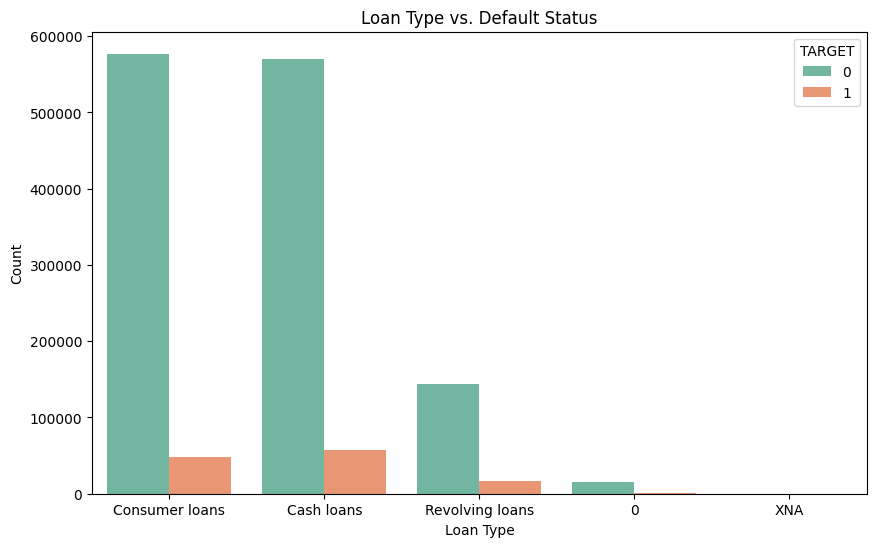

In [22]:
# Differences in approval rates between different types of loans (cash vs. revolving)
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_CONTRACT_TYPE_y', hue='TARGET', data=merged_data, palette='Set2')
plt.title('Loan Type vs. Default Status')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.show()

In [23]:
# Statistical Analysis: Hypothesis Testing (Example: Difference in default rates between loan types)
cash_loan_default = merged_data[merged_data['NAME_CONTRACT_TYPE_y'] == 'Cash loans']['TARGET']
revolving_loan_default = merged_data[merged_data['NAME_CONTRACT_TYPE_y'] == 'Revolving loans']['TARGET']
t_stat, p_val_loan_type = ttest_ind(cash_loan_default, revolving_loan_default)
print("T-test p-value for loan type and default rate:", p_val_loan_type)

T-test p-value for loan type and default rate: 4.7165313854250364e-61


In [24]:
# Calculate Income to Debt ratio
merged_data['INCOME_TO_DEBT_RATIO'] = merged_data['AMT_INCOME_TOTAL'] / merged_data['AMT_CREDIT_x']

# Display the calculated ratio
print("Income to Debt Ratio:")
print(merged_data[['SK_ID_CURR', 'INCOME_TO_DEBT_RATIO']])

Income to Debt Ratio:
         SK_ID_CURR  INCOME_TO_DEBT_RATIO
0            100002              0.498036
1            100003              0.208736
2            100003              0.208736
3            100003              0.208736
4            100004              0.500000
...             ...                   ...
1430150      456255              0.233333
1430151      456255              0.233333
1430152      456255              0.233333
1430153      456255              0.233333
1430154      456255              0.233333

[1430155 rows x 2 columns]


Financial Analysis

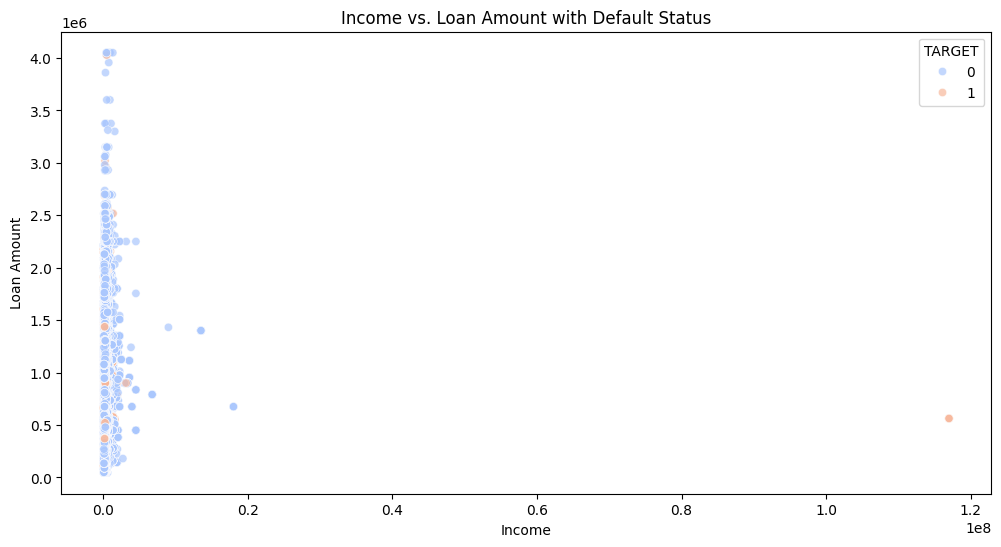

In [25]:
# Relationship between income, debt levels, and loan default probability
plt.figure(figsize=(12, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='AMT_CREDIT_x', hue='TARGET', data=merged_data, palette='coolwarm', alpha=0.7)
plt.title('Income vs. Loan Amount with Default Status')
plt.xlabel('Income')
plt.ylabel('Loan Amount')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\3882810402.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_14620\3882810402.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)


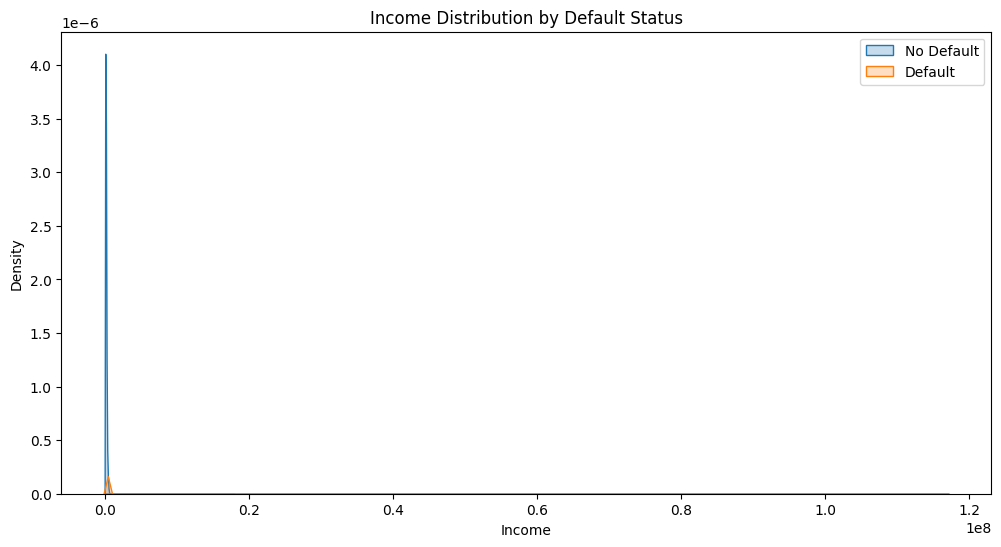

In [26]:
# Income distribution among loan applicants and its influence on loan amounts and approval rates
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'AMT_INCOME_TOTAL'], label='No Default', shade=True)
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'AMT_INCOME_TOTAL'], label='Default', shade=True)
plt.title('Income Distribution by Default Status')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

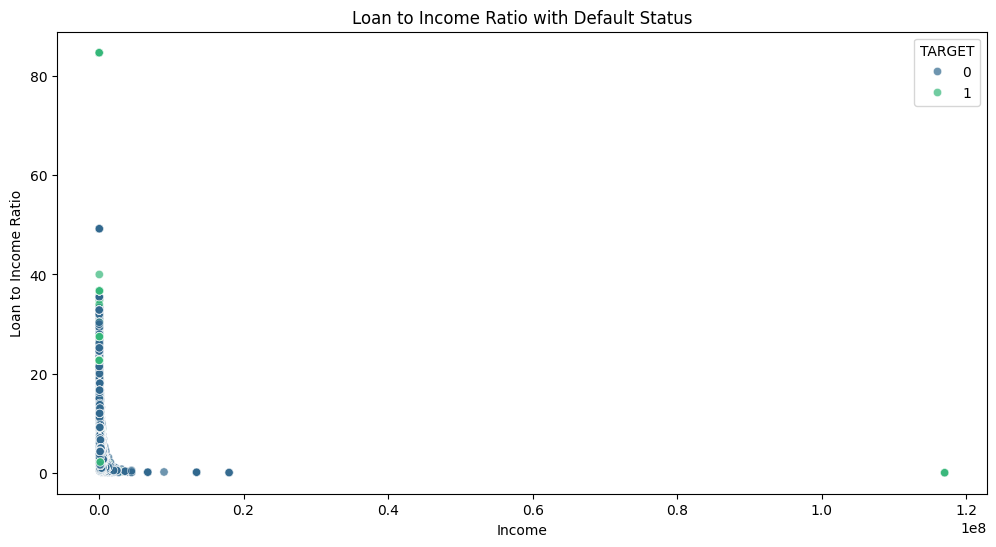

In [27]:
# Loan amount requested compared to income levels and its impact on default rates
merged_data['LOAN_TO_INCOME_RATIO'] = merged_data['AMT_CREDIT_x'] / merged_data['AMT_INCOME_TOTAL']

plt.figure(figsize=(12, 6))
sns.scatterplot(x='AMT_INCOME_TOTAL', y='LOAN_TO_INCOME_RATIO', hue='TARGET', data=merged_data, palette='viridis', alpha=0.7)
plt.title('Loan to Income Ratio with Default Status')
plt.xlabel('Income')
plt.ylabel('Loan to Income Ratio')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\788985182.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'LOAN_TO_INCOME_RATIO'], label='No Default', shade=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_14620\788985182.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'LOAN_TO_INCOME_RATIO'], label='Default', shade=True)


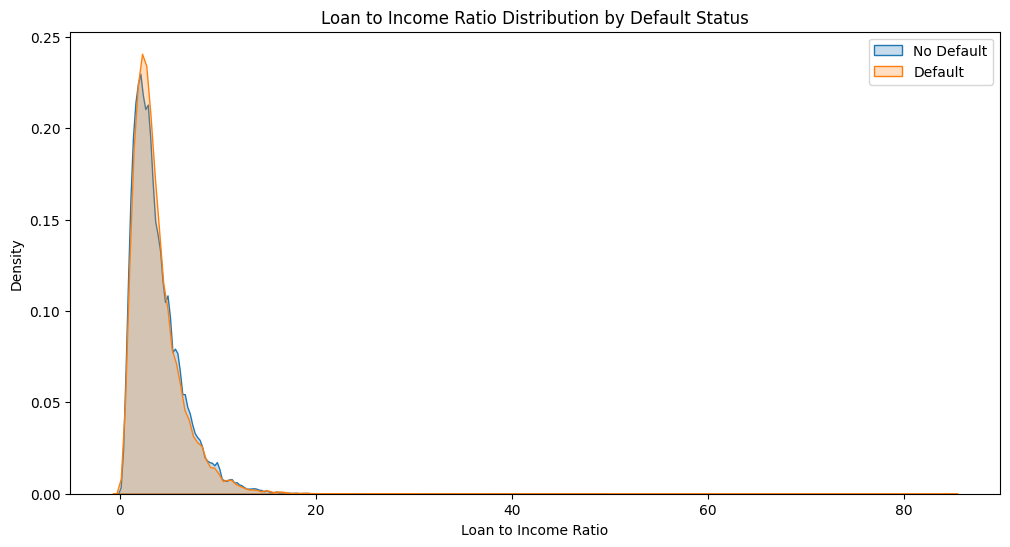

In [28]:
# Analysis of loan amount requested compared to income levels and its impact on default rates
plt.figure(figsize=(12, 6))
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 0, 'LOAN_TO_INCOME_RATIO'], label='No Default', shade=True)
sns.kdeplot(merged_data.loc[merged_data['TARGET'] == 1, 'LOAN_TO_INCOME_RATIO'], label='Default', shade=True)
plt.title('Loan to Income Ratio Distribution by Default Status')
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Density')
plt.legend()
plt.show()

In these visualizations:

The first scatter plot shows the relationship between income and loan amounts, with default status indicated by color.

The second plot displays the income distribution among loan applicants, differentiating between default and non-default cases.

The third scatter plot illustrates the loan to income ratio, and how it relates to income levels with default status indicated by color.

The fourth plot provides the distribution of the loan to income ratio, separated by default and non-default cases.

Credit History Analysis

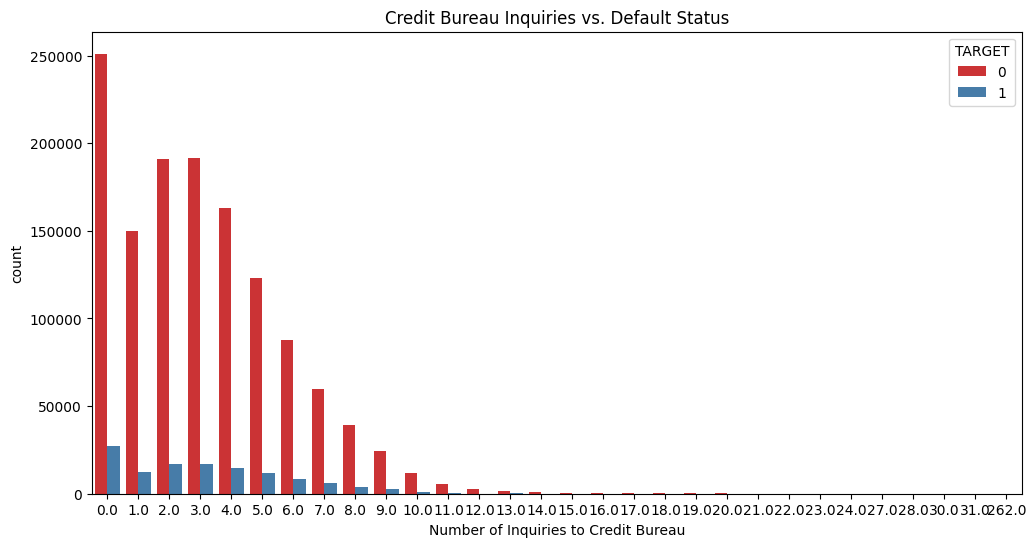

In [29]:
# Calculate the total number of credit bureau inquiries
merged_data['AMT_REQ_CREDIT_BUREAU_TOTAL'] = merged_data[['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

# Visualize the impact
plt.figure(figsize=(12, 6))
sns.countplot(x='AMT_REQ_CREDIT_BUREAU_TOTAL', hue='TARGET', data=merged_data, palette='Set1')
plt.title('Credit Bureau Inquiries vs. Default Status')
plt.xlabel('Number of Inquiries to Credit Bureau')
plt.show()

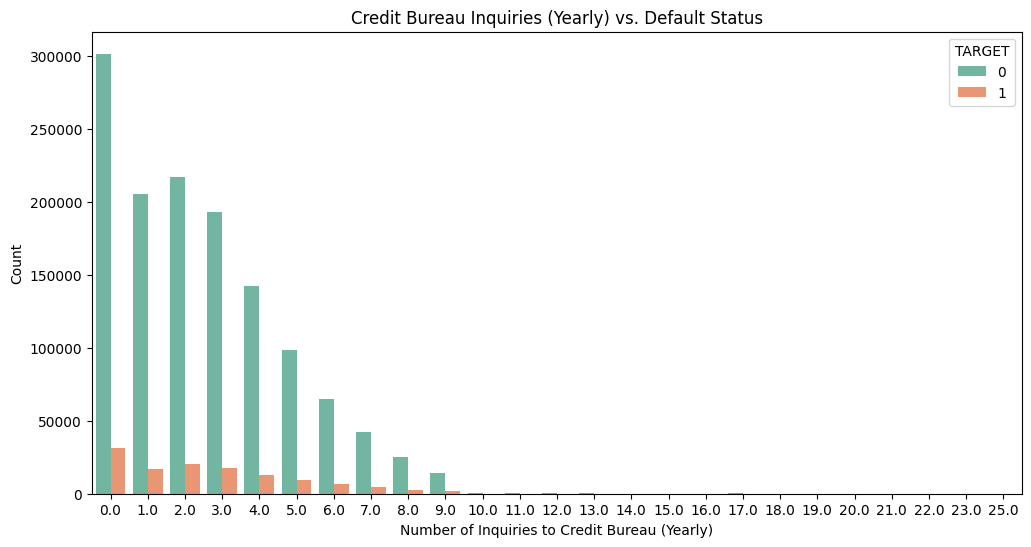

In [30]:
# Impact of past defaults on creditworthiness
plt.figure(figsize=(12, 6))
sns.countplot(x='AMT_REQ_CREDIT_BUREAU_YEAR', hue='TARGET', data=merged_data, palette='Set2')
plt.title('Credit Bureau Inquiries (Yearly) vs. Default Status')
plt.xlabel('Number of Inquiries to Credit Bureau (Yearly)')
plt.ylabel('Count')
plt.show()

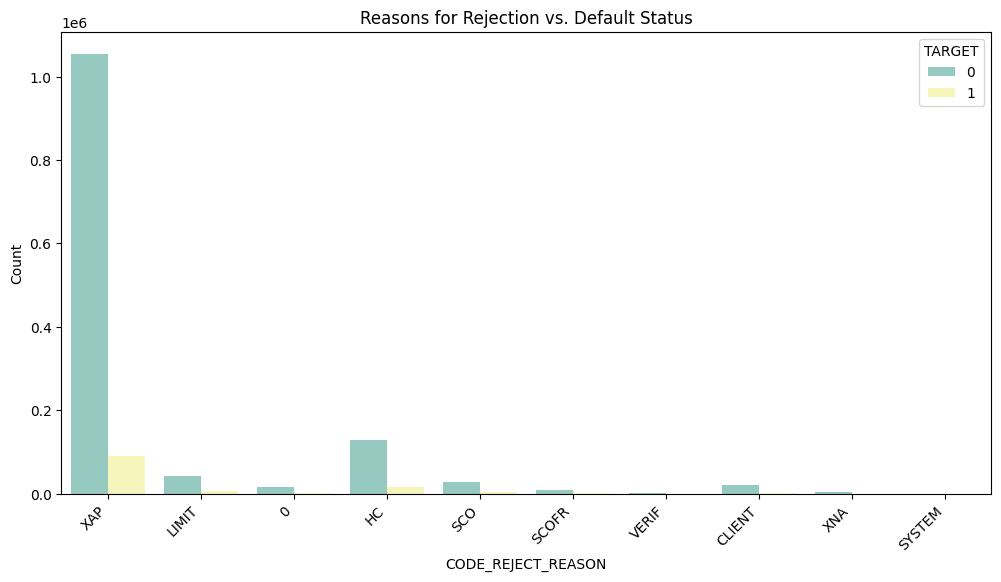

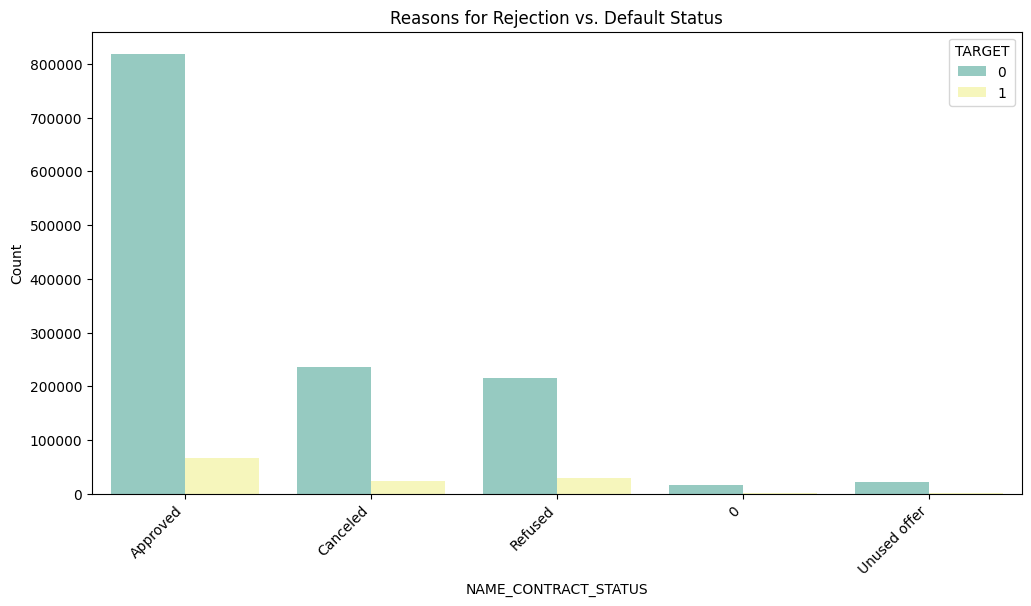

In [31]:
# Relationships between credit risk and reasons for rejection of previous loan application
rejection_reasons = ['CODE_REJECT_REASON', 'NAME_CONTRACT_STATUS']

for reason in rejection_reasons:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=reason, hue='TARGET', data=merged_data, palette='Set3')
    plt.title(f'Reasons for Rejection vs. Default Status')
    plt.xlabel(reason)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

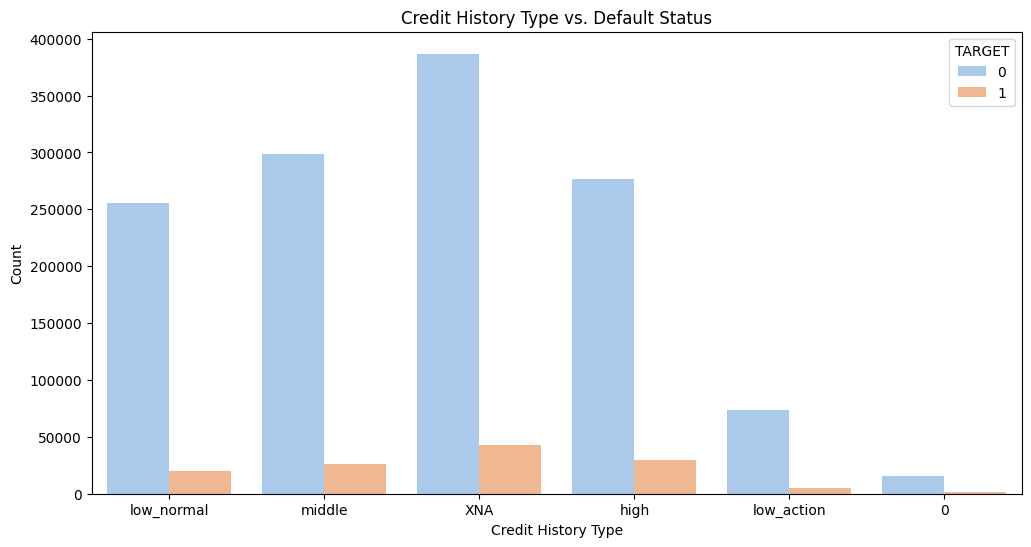

In [32]:
# Type of credit history vs. default risk assessment
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_YIELD_GROUP', hue='TARGET', data=merged_data, palette='pastel')
plt.title('Credit History Type vs. Default Status')
plt.xlabel('Credit History Type')
plt.ylabel('Count')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\771530373.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DAYS_DECISION', y='TARGET', data=merged_data, palette='pastel', orient='h')


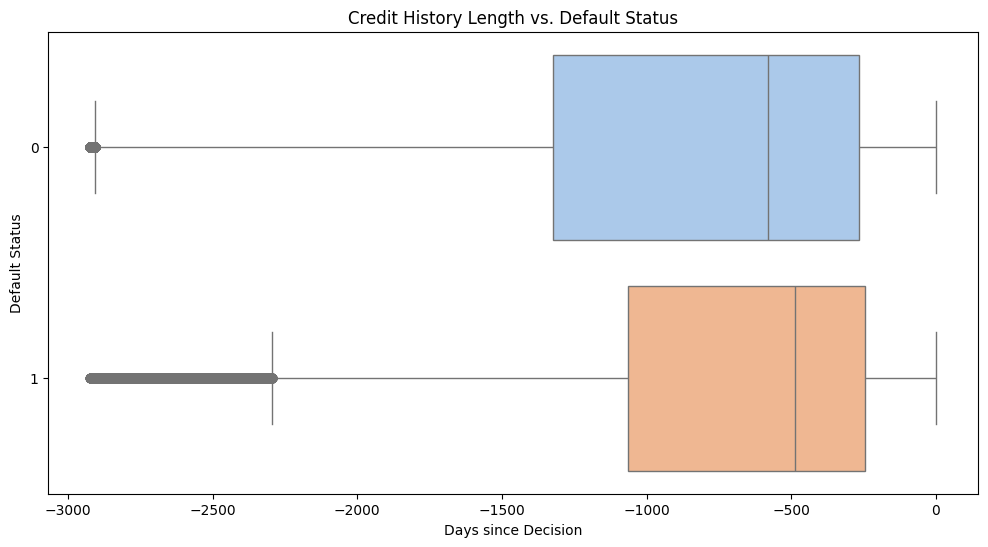

In [33]:
# Length of credit history vs. default risk assessment
plt.figure(figsize=(12, 6))
sns.boxplot(x='DAYS_DECISION', y='TARGET', data=merged_data, palette='pastel', orient='h')
plt.title('Credit History Length vs. Default Status')
plt.xlabel('Days since Decision')
plt.ylabel('Default Status')
plt.show()


In these visualizations:

The first two count plots show the impact of the number of inquiries to the Credit Bureau on default status, both overall and on a yearly basis.

The following count plots explore the relationships between credit risk and reasons for the rejection of previous loan applications.

The final plots analyze the type of credit history (represented by NAME_YIELD_GROUP) and the length of credit history (represented by DAYS_DECISION) in relation to default risk assessment.

Loan Application Decision Analysis

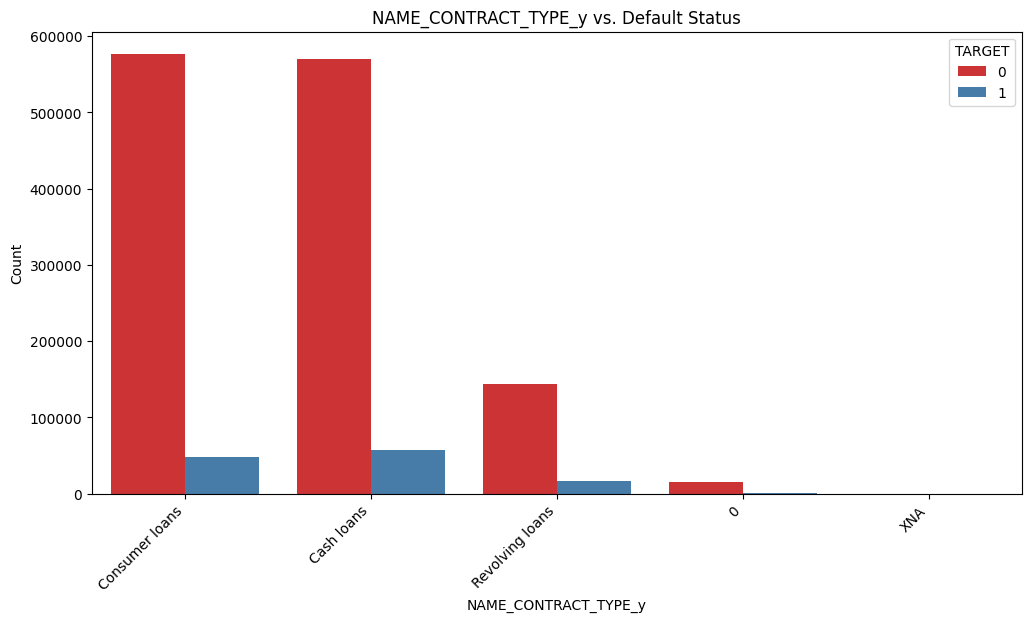

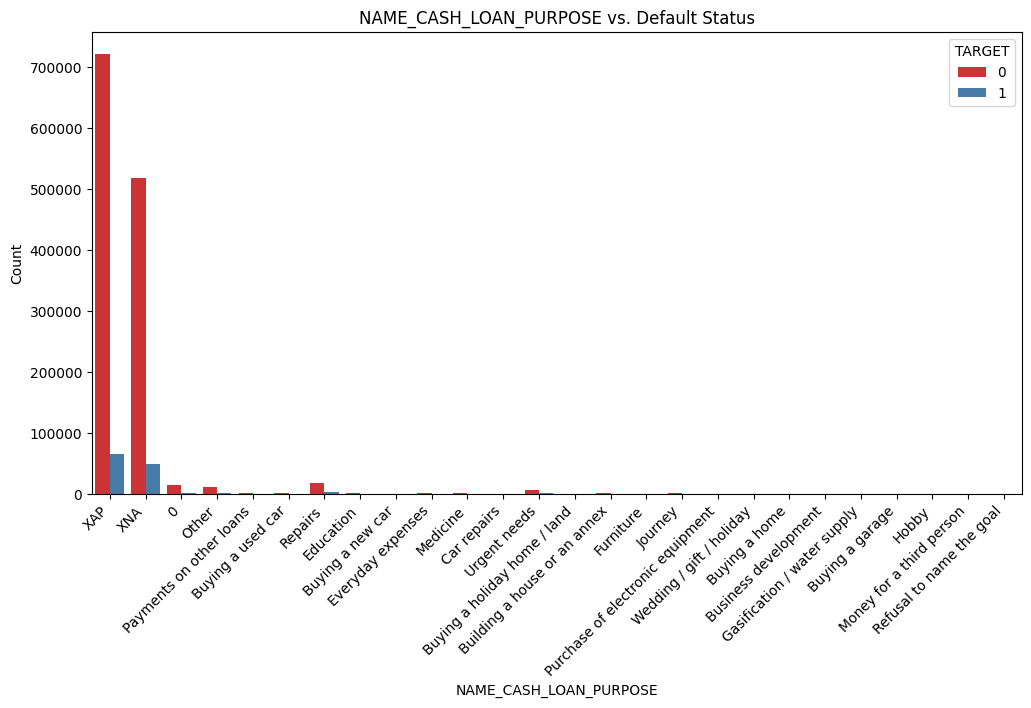

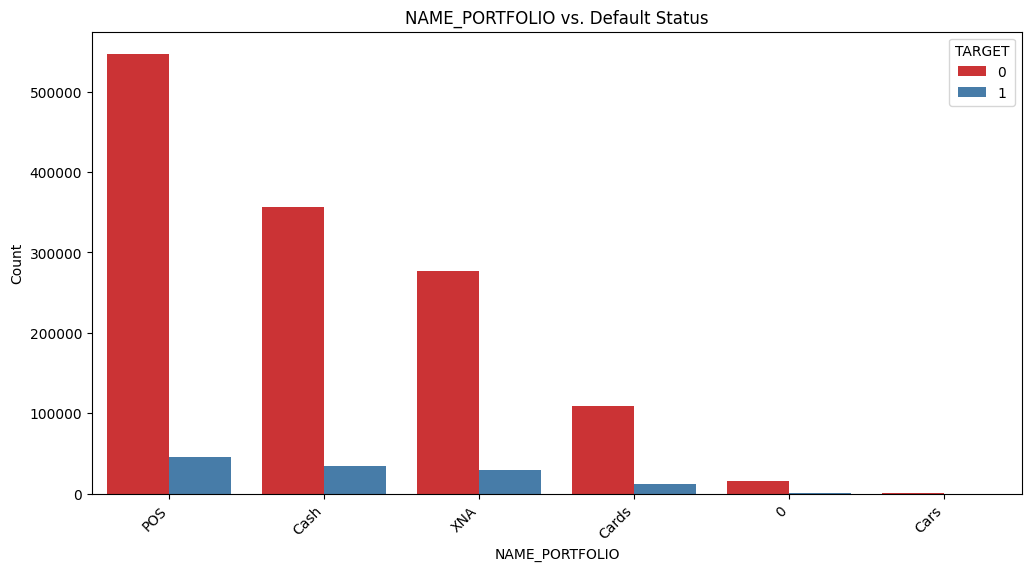

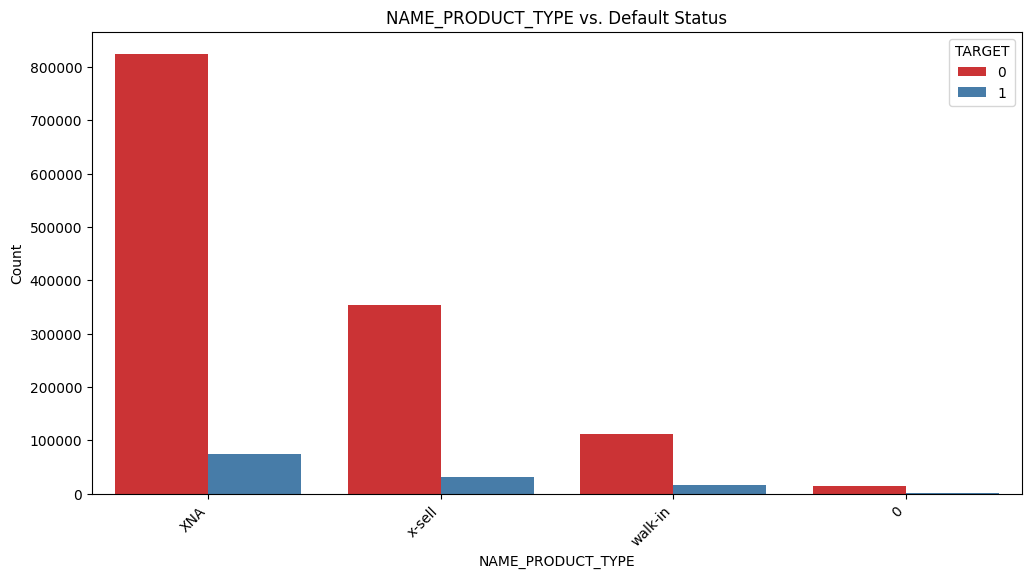

In [34]:
# Correlation between loan types, amounts, or purposes and default risk
loan_types = ['NAME_CONTRACT_TYPE_y', 'NAME_CASH_LOAN_PURPOSE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE']

for loan_type in loan_types:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=loan_type, hue='TARGET', data=merged_data, palette='Set1')
    plt.title(f'{loan_type} vs. Default Status')
    plt.xlabel(loan_type)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

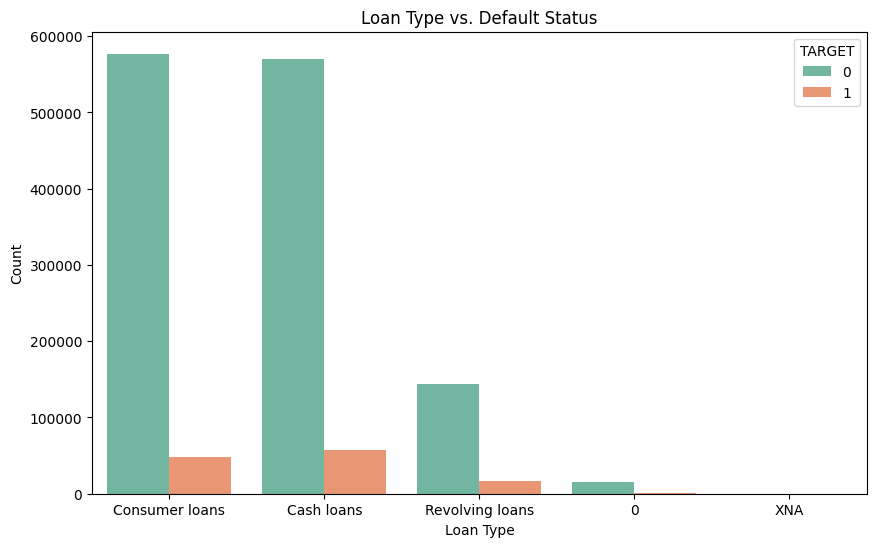

In [35]:
# Differences in approval rates between different types of loans (cash vs. revolving)
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_CONTRACT_TYPE_y', hue='TARGET', data=merged_data, palette='Set2')
plt.title('Loan Type vs. Default Status')
plt.xlabel('Loan Type')
plt.ylabel('Count')
plt.show()

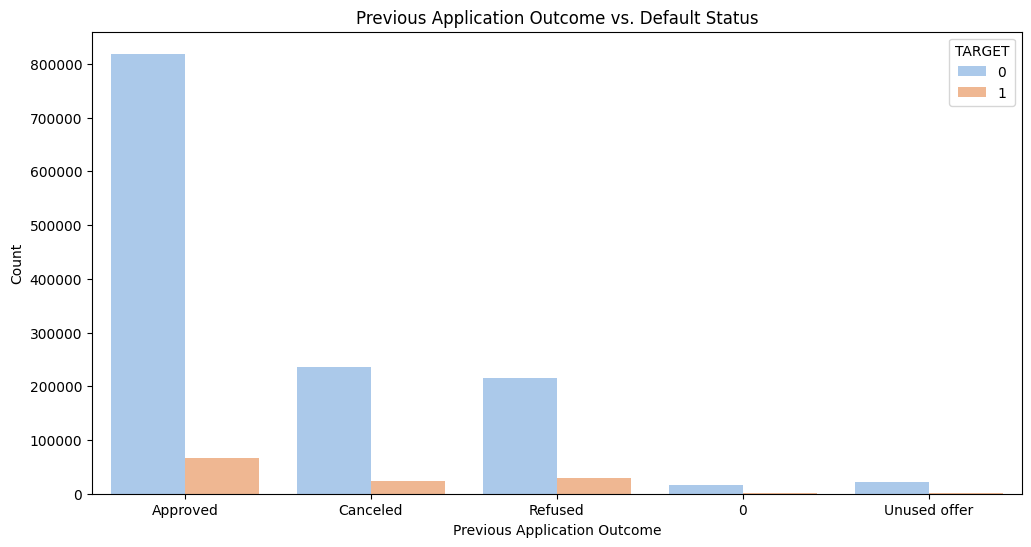

In [36]:
# Previous application outcomes affecting future default risk
plt.figure(figsize=(12, 6))
sns.countplot(x='NAME_CONTRACT_STATUS', hue='TARGET', data=merged_data, palette='pastel')
plt.title('Previous Application Outcome vs. Default Status')
plt.xlabel('Previous Application Outcome')
plt.ylabel('Count')
plt.show()

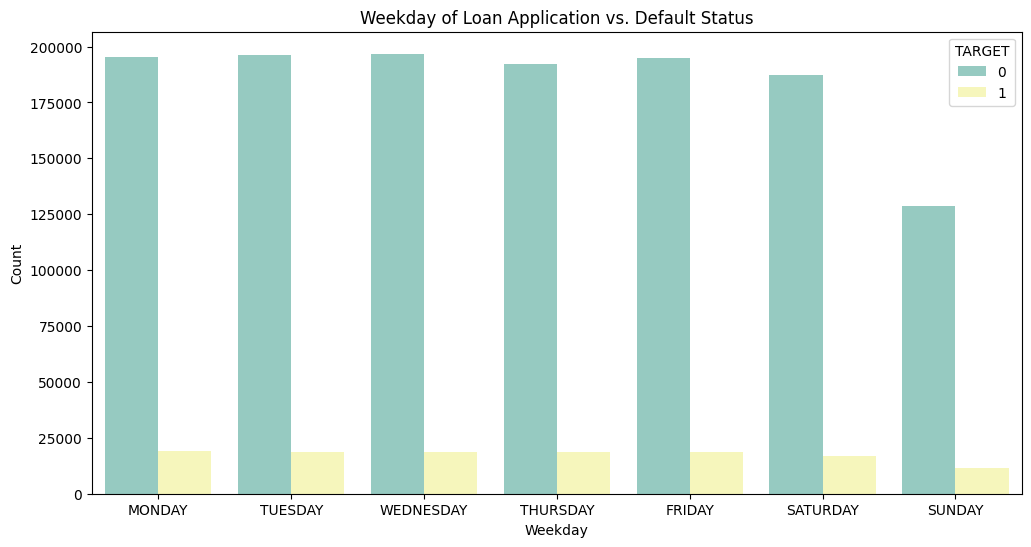

In [37]:
# Correlations between the client's credit risk and the weekday they applied for the loan
plt.figure(figsize=(12, 6))
sns.countplot(x='WEEKDAY_APPR_PROCESS_START_y', hue='TARGET', data=merged_data, palette='Set3', order=['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY'])
plt.title('Weekday of Loan Application vs. Default Status')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()

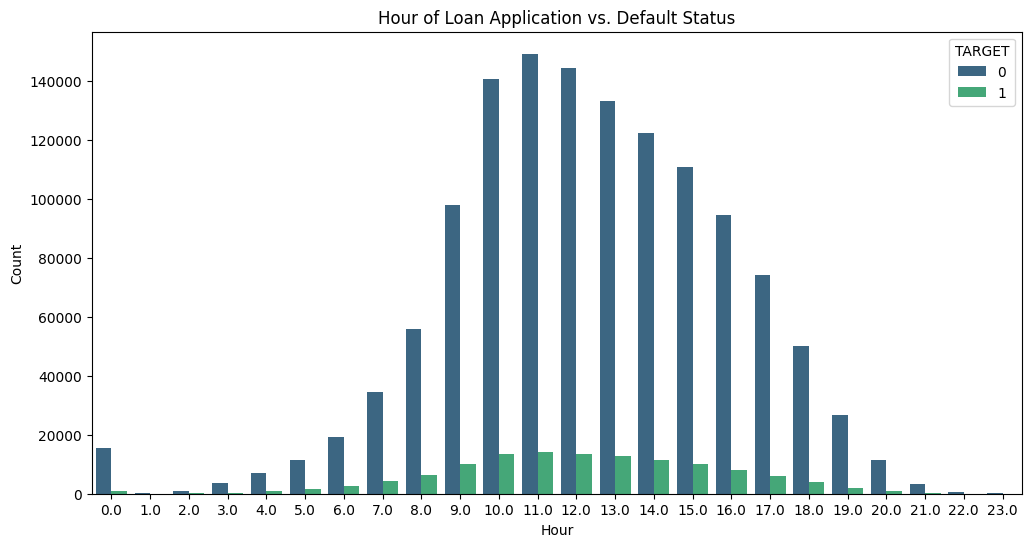

In [38]:
# Correlations between the client's credit risk and the hour they applied for the loan
plt.figure(figsize=(12, 6))
sns.countplot(x='HOUR_APPR_PROCESS_START_y', hue='TARGET', data=merged_data, palette='viridis')
plt.title('Hour of Loan Application vs. Default Status')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

In these visualizations:

The first set of count plots explores how specific loan types, amounts, or purposes correlate with default risk.

The second plot compares approval rates between different types of loans (cash vs. revolving).

The third plot examines how previous application outcomes (approval, refusal) affect future default risk.

The final two plots analyze correlations between the client's credit risk and the weekday or hour they applied for the loan.

Feature Importance Analysis

In [39]:
# Select relevant features for training the model
selected_features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
                     'EXT_SOURCE_3', 'AMT_REQ_CREDIT_BUREAU_TOTAL', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_TYPE_x',
                     'NAME_CASH_LOAN_PURPOSE', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'NAME_CONTRACT_STATUS',
                     'WEEKDAY_APPR_PROCESS_START_y', 'HOUR_APPR_PROCESS_START_y', 'NAME_YIELD_GROUP', 'DAYS_DECISION',
                     'LOAN_TO_INCOME_RATIO']

X = merged_data[selected_features]
y = merged_data['TARGET']

# Data preprocessing - handle missing values, convert categorical variables, etc.
X.fillna(0, inplace=True)  # Replace missing values with 0 for simplicity
X = pd.get_dummies(X)  # One-hot encode categorical variables if any

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Random Forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features and Their Importance:")
print(feature_importance_df.head(10))

# Make predictions on the test set for further analysis
y_pred = model.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\3172988683.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)  # Replace missing values with 0 for simplicity


Top Features and Their Importance:
                      Feature  Importance
5                EXT_SOURCE_2    0.115900
2                  DAYS_BIRTH    0.095869
6                EXT_SOURCE_3    0.094788
11       LOAN_TO_INCOME_RATIO    0.089540
1                AMT_CREDIT_x    0.083992
3               DAYS_EMPLOYED    0.083248
10              DAYS_DECISION    0.076023
0            AMT_INCOME_TOTAL    0.065958
4                EXT_SOURCE_1    0.053652
9   HOUR_APPR_PROCESS_START_y    0.049360

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97    261296
           1       1.00      0.28      0.44     24735

    accuracy                           0.94    286031
   macro avg       0.97      0.64      0.71    286031
weighted avg       0.94      0.94      0.92    286031



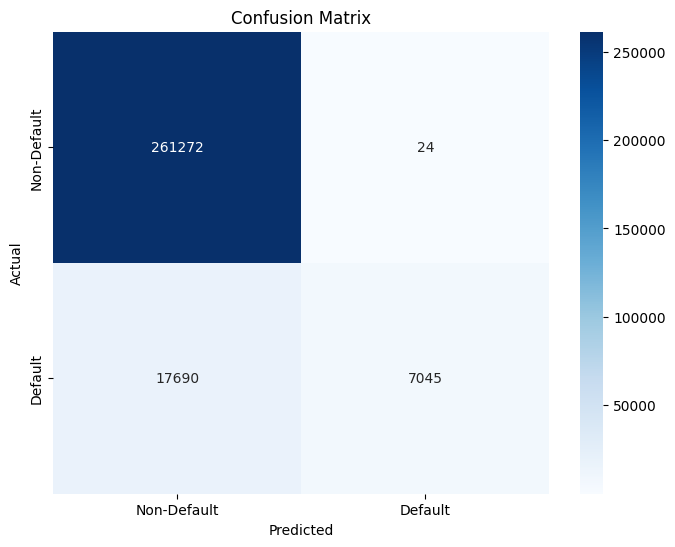

In [42]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Default', 'Default'], yticklabels=['Non-Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

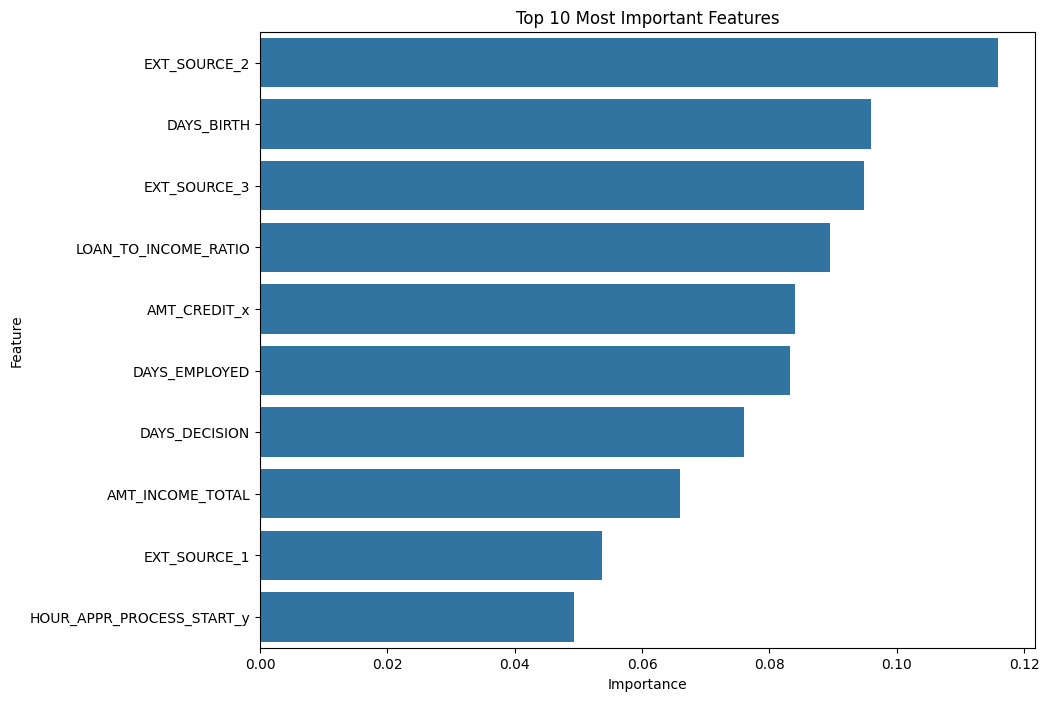

In [43]:
# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()

In [44]:
# Logistic Regression with Data Preprocessing and Model Training
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
lr_predictions = lr_model.predict_proba(X_test_scaled)[:, 1]

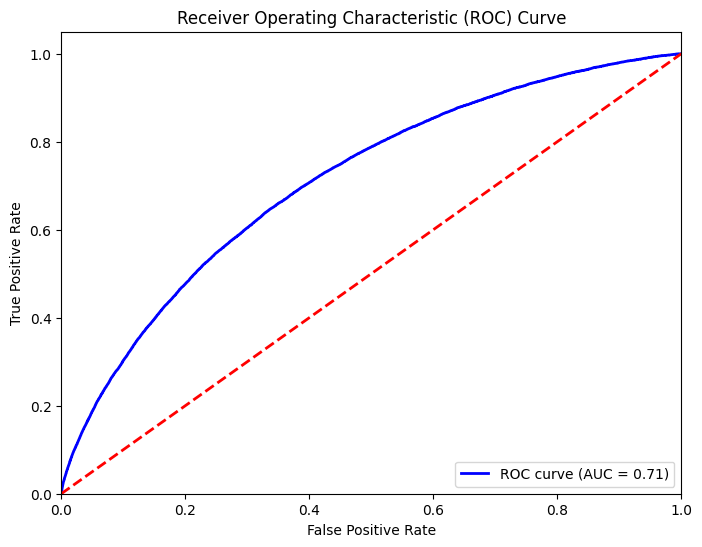

In [45]:
# ROC Curve Analysis
fpr, tpr, thresholds = roc_curve(y_test, lr_predictions)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [46]:
# Recursive Feature Elimination
rfe = RFE(estimator=lr_model, n_features_to_select=5, step=1)
rfe.fit(X_train_scaled, y_train)
selected_features = X.columns[rfe.support_]

print("Selected Features after Recursive Feature Elimination:")
print(selected_features)

Selected Features after Recursive Feature Elimination:
Index(['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
       'NAME_CONTRACT_TYPE_x_Cash loans'],
      dtype='object')


In this code:

We selected a set of relevant features for training the model based on previous analyses.

The Random Forest classifier is trained on the selected features.

Feature importances are extracted from the trained model and displayed in a DataFrame.

The top features and their importance scores are printed.

Additionally, a classification report is generated to evaluate the model's performance.

Portfolio and Risk Assessment

1. Segmenting Clients Based on Risk Profiles:

In [47]:
# Create risk profiles based on credit risk features
risk_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_x', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH']

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\1932879553.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y='RISK_PROFILE', x='TARGET', data=subset_data, palette='pastel')


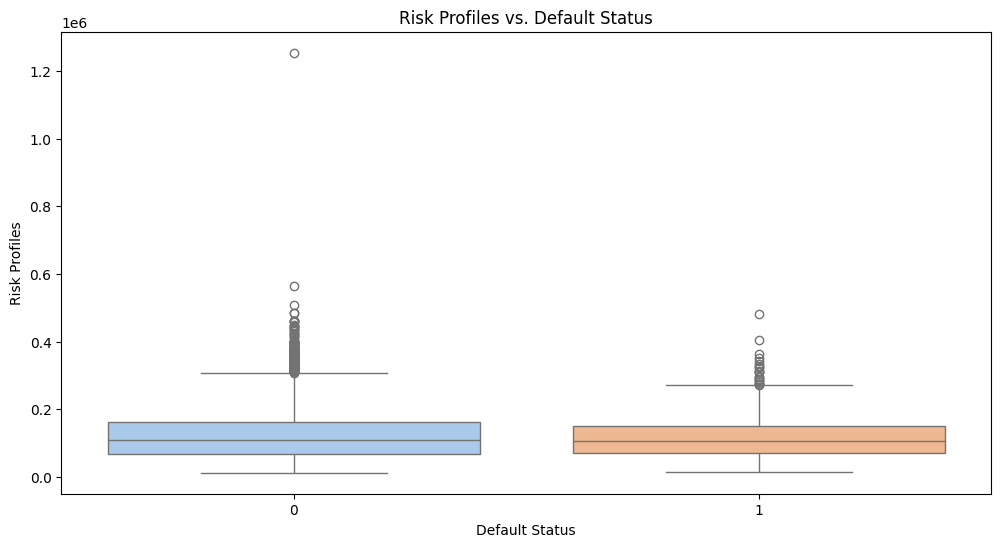

In [48]:
# Use a random sample of 10,000 rows
subset_data = merged_data.sample(n=10000, random_state=42)

# Calculate risk profiles and visualize
subset_data['RISK_PROFILE'] = subset_data[risk_features].mean(axis=1)
plt.figure(figsize=(12, 6))
sns.boxplot(y='RISK_PROFILE', x='TARGET', data=subset_data, palette='pastel')
plt.title('Risk Profiles vs. Default Status')
plt.xlabel('Default Status')
plt.ylabel('Risk Profiles')
plt.show()


2. Identifying Segments with Higher Default Risk Based on Portfolio Characteristics:

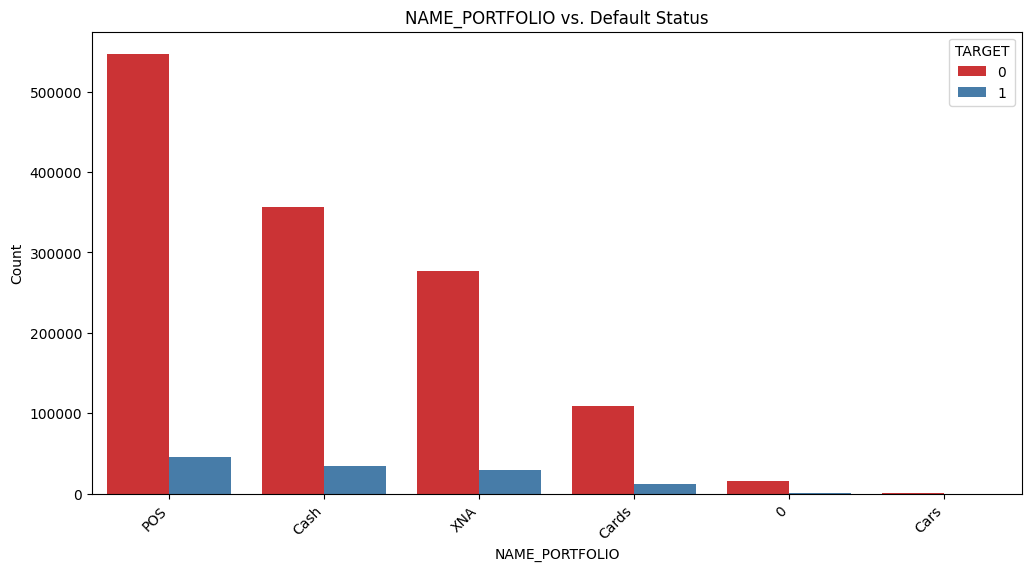

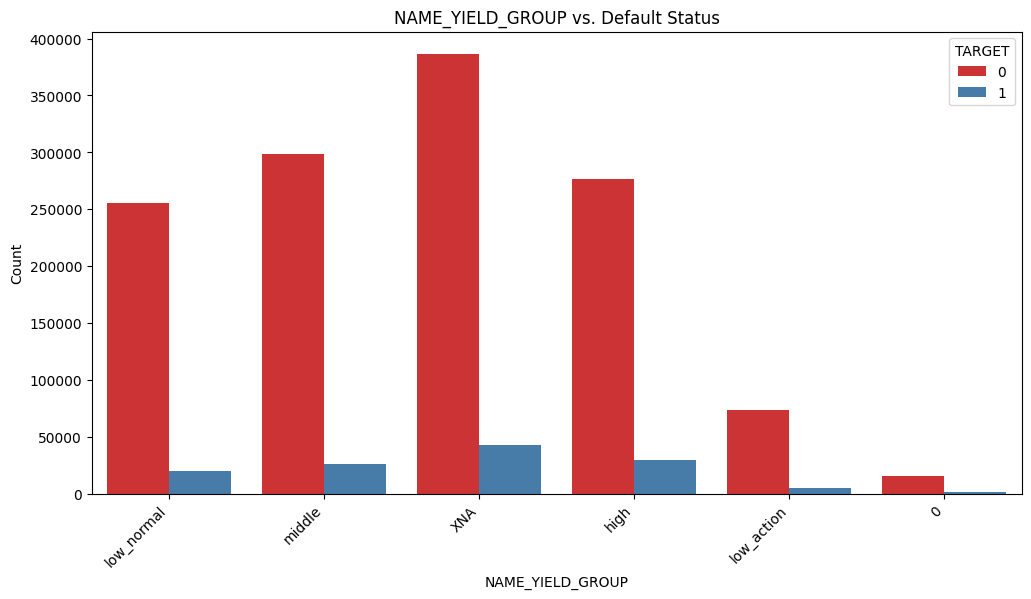

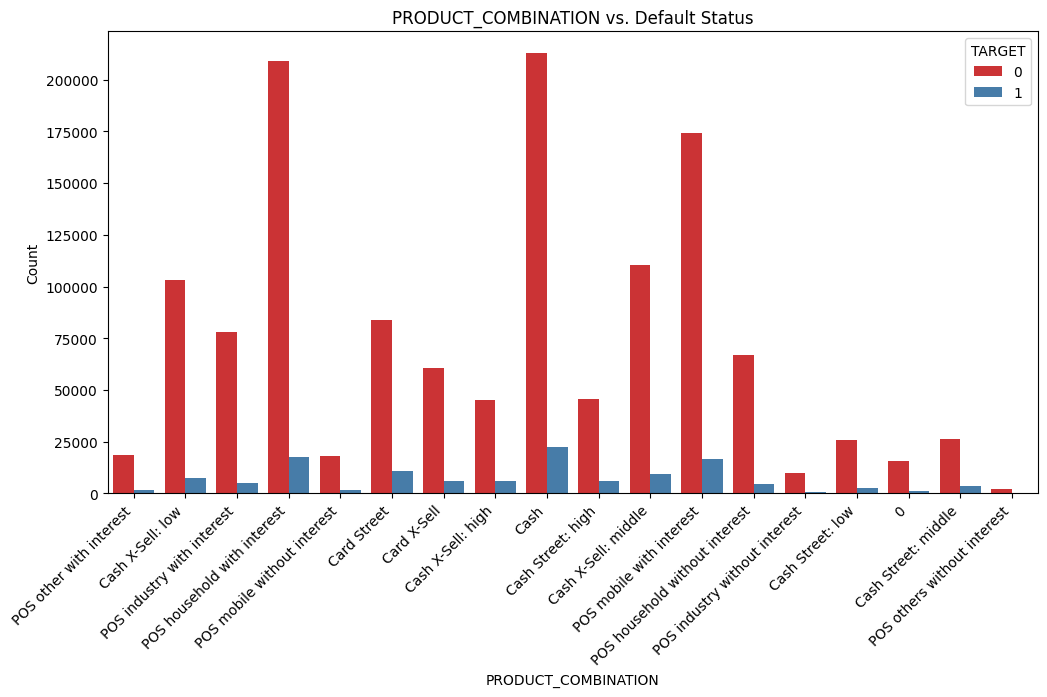

In [49]:
# Analyze portfolio characteristics and default risk
portfolio_features = ['NAME_PORTFOLIO', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']

for feature in portfolio_features:
    plt.figure(figsize=(12, 6))
    sns.countplot(x=feature, hue='TARGET', data=merged_data, palette='Set1')
    plt.title(f'{feature} vs. Default Status')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()


3. Trends or Patterns in Default Rates Over Time:

C:\Users\HP\AppData\Local\Temp\ipykernel_14620\821831491.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='DAYS_DECISION', y='TARGET', data=merged_data, ci=None)


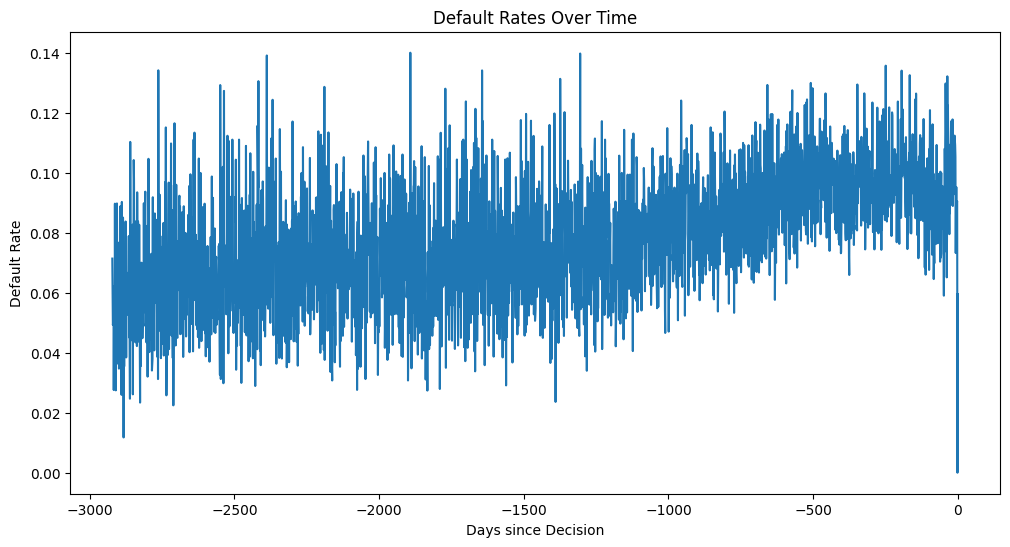

In [52]:
# Analyze trends in default rates over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='DAYS_DECISION', y='TARGET', data=merged_data, ci=None)
plt.title('Default Rates Over Time')
plt.xlabel('Days since Decision')
plt.ylabel('Default Rate')
plt.show()
